## 0. Konfiguracja środowiska i import bibliotek

W tej sekcji przygotowujemy środowisko pracy. Projekt opiera się na analizie danych tabelarycznych oraz wizualizacji, dlatego wykorzystujemy standardowy stos technologiczny:

1.  **Manipulacja danymi:** Biblioteka `pandas` posłuży do wczytania plików CSV, czyszczenia danych i agregacji, a `numpy` do operacji matematycznych (np. logarytmowanie).
2.  **Wizualizacja:** Używamy `matplotlib` jako fundamentu oraz `seaborn` do tworzenia estetycznych wykresów statystycznych (np. boxploty, heatmapy).
3.  **Obsługa plików:** Moduły `pathlib` oraz `re` (wyrażenia regularne) są niezbędne, ponieważ nasz zbiór danych jest podzielony na wiele plików (snapshotów czasowych), a data pobrania danych zawarta jest w nazwie pliku, a nie w jego treści.

Dodatkowo konfigurujemy parametry wyświetlania (`pd.set_option`), aby ramki danych w notatniku były czytelne (widoczność wszystkich kolumn) i nie były "łamane" w podglądzie.

`HTML` z IPython.display używamy by móc umieścić kod HTML w naszym notatniku. Pozwala nam on na czytelniejszą prezentacje wyników.

In [ ]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
from scipy.stats import norm

pd.set_option("display.max_columns", None)         # pokazuj wszystkie kolumny
# pd.set_option("display.width", 2000)               # większa "szerokość" wydruku
# pd.set_option("display.max_colwidth", 80)          # limit szerokości komórki (ustaw np. None, jeśli chcesz bez limitu)
pd.set_option("display.expand_frame_repr", False)  # nie łam DataFrame na kilka "bloków" w pionie

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = Path("data")  # folder z CSV
CSV_GLOB = "*.csv"

SNAPSHOT_RE = re.compile(r"(?P<year>20\d{2})[_-](?P<month>\d{2})")

Wylistowanie dostępnych zbiorów danych z plików CSV.

In [2]:
paths = sorted(DATA_DIR.glob(CSV_GLOB))
if not paths:
    raise FileNotFoundError(f"Brak plików CSV w: {DATA_DIR.resolve()}")

[p.name for p in paths[:10]], len(paths)

(['apartments_pl_2023_08.csv',
  'apartments_pl_2023_09.csv',
  'apartments_pl_2023_10.csv',
  'apartments_pl_2023_11.csv',
  'apartments_pl_2023_12.csv',
  'apartments_pl_2024_01.csv',
  'apartments_pl_2024_02.csv',
  'apartments_pl_2024_03.csv',
  'apartments_pl_2024_04.csv',
  'apartments_pl_2024_05.csv'],
 19)

## 1. Wczytanie danych, wstępna agregacja i ich podział

Ponieważ dane surowe są rozproszone w wielu plikach CSV (reprezentujących różne "zrzuty" danych w czasie), konieczna jest ich agregacja do jednej, spójnej struktury. Poniższy kod realizuje ten proces w kilku krokach:

1.  **Iteracyjne wczytywanie:** W pętli przechodzimy przez listę ścieżek do plików. Każdy plik jest wczytywany do osobnej ramki danych (`df`).
2.  **Ekstrakcja metadanych czasowych:** Kluczowa informacja o dacie pobrania danych nie znajduje się wewnątrz pliku CSV, lecz w jego nazwie (np. `...2024_06...`). Używając zdefiniowanego wcześniej wyrażenia regularnego (`SNAPSHOT_RE`), wyciągamy rok i miesiąc, a następnie konwertujemy je na obiekt `pd.Timestamp`. Pozwala to na późniejszą analizę trendów w czasie.
3.  **Śledzenie źródła:** Dodajemy kolumnę `source_file`, aby zachować informację o pochodzeniu każdego rekordu (Data Lineage) – ułatwia to namierzanie ewentualnych błędów w konkretnych plikach.
4.  **Konsolidacja (Concatenation):** Wszystkie mniejsze ramki danych są łączone w jedną główną ramkę `df_all` za pomocą funkcji `pd.concat`. Resetujemy indeks (`ignore_index=True`), aby zachować ciągłość numeracji wierszy.
5.  **Feature Engineering (Cena za m²):** Już na tym etapie tworzymy nową cechę `price_per_m2`. Jest to najbardziej miarodajny wskaźnik na rynku nieruchomości, pozwalający porównywać wartość mieszkań o różnym metrażu.

In [3]:
dfs = []

for p in paths:
    df = pd.read_csv(p)

    # snapshot_date z nazwy pliku: YYYY_MM lub YYYY-MM -> YYYY-MM-01
    m = SNAPSHOT_RE.search(p.name)
    snapshot_date = pd.NaT
    if m:
        snapshot_date = pd.Timestamp(year=int(m.group("year")), month=int(m.group("month")), day=1)

    df["source_file"] = p.name
    df["snapshot_date"] = snapshot_date
    df["snapshot_year"] = pd.to_datetime(df["snapshot_date"]).dt.year
    df["snapshot_month"] = pd.to_datetime(df["snapshot_date"]).dt.month

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['price_per_m2'] = df_all['price'] / df_all['squareMeters']
df_all.shape

display(df_all[['city', 'price', 'squareMeters', 'price_per_m2']].head())

,city,price,squareMeters,price_per_m2
0,szczecin,415000,63.00,6587.301587
1,szczecin,395995,36.00,10999.861111
2,szczecin,565000,73.02,7737.606135
3,szczecin,640000,87.60,7305.936073
4,szczecin,759000,66.00,11500.000000


### Podział danych na podzbiory (Sprzedaż vs Wynajem)

Ze względu na to, że zbiór danych zawiera zmieszane oferty sprzedaży i wynajmu (które mają drastycznie różne ceny), dzielimy główną ramkę `df_all` na dwie niezależne części:
1.  **Wynajem (`df_rent`):** Wyodrębniamy rekordy, których nazwa pliku źródłowego (`source_file`) zawiera słowo "rent".
2.  **Sprzedaż (`df_sell`):** Do tego zbioru trafiają wszystkie pozostałe rekordy (operator `~` oznacza logiczną negację maski wynajmu).

Użycie metody `.copy()` jest tutaj kluczowe – tworzy ona fizyczną kopię danych w pamięci, dzięki czemu późniejsze czyszczenie jednego zbioru nie wpływa na drugi.

In [4]:
# Rozpoznanie po nazwie pliku (source_file)
# rent -> ma "rent" w nazwie
mask_rent = df_all["source_file"].str.lower().str.contains("rent", na=False)

# sell/ceny -> wszystko co NIE jest rent
mask_sell = ~mask_rent

df_rent = df_all[mask_rent].copy()
df_sell = df_all[mask_sell].copy()

df_rent.shape, df_sell.shape

((70847, 33), (195568, 33))

### Weryfikacja niezaklasyfikowanych rekordów

Tworzymy pomocniczy zbiór `df_other`, trafiają do niego rekordy, które nie zostały przypisane ani do kategorii sprzedaży, ani wynajmu (np. z powodu nietypowych nazw plików). Sprawdzamy liczebność i źródła tych danych, aby upewnić się, że nie pomijamy istotnych informacji w procesie podziału. Dla naszych danych oczekujemy pustej ramki.

In [5]:
df_other = df_all[~(mask_rent | mask_sell)].copy()
df_other["source_file"].value_counts().head(20), df_other.shape

(Series([], Name: count, dtype: int64), (0, 33))

## 2. Wstępna Obróbka Danych

Surowy zbiór danych składa się z ofert agregowanych z wielu okresów (tzw. *snapshotów*). W pierwszej kolejności dokonujemy podziału danych na dwa niezależne podzbiory:
* **Sprzedaż (`df_sell`)**: Oferty sprzedaży mieszkań.
* **Wynajem (`df_rent`)**: Oferty wynajmu mieszkań.

Podział ten jest kluczowy, ponieważ mechanizmy cenowe rządzące rynkiem sprzedaży (cena całkowita, kredyty) różnią się fundamentalnie od rynku najmu (czynsz miesięczny, stopa zwrotu), co wymagałoby budowy osobnych modeli predykcyjnych.

Poniżej przedstawiamy podstawowe statystyki dla obu wyodrębnionych grup.

Zbiór,Liczba ofert,Liczba kolumn,Liczba miast,Zakres dat
Sprzedaż (Sell),195568,32,15,2023-08-01 — 2024-06-01
Wynajem (Rent),70847,32,15,2023-11-01 — 2024-06-01


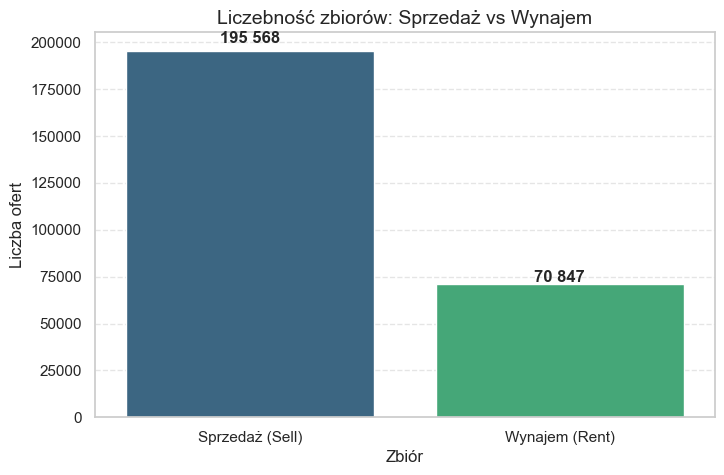

In [47]:
# Funkcja pomocnicza do raportowania zakresu dat
def get_date_range(df):
    if 'snapshot_date' in df.columns:
        d_min = df['snapshot_date'].min()
        d_max = df['snapshot_date'].max()
        return f"{d_min.date()} — {d_max.date()}"
    return "Brak danych czasowych"

# 1. Obliczenie statystyk
stats = {
    'Zbiór': ['Sprzedaż (Sell)', 'Wynajem (Rent)'],
    'Liczba ofert': [len(df_sell), len(df_rent)],
    'Liczba kolumn': [df_sell.shape[1], df_rent.shape[1]],
    'Liczba miast': [df_sell['city'].nunique(), df_rent['city'].nunique()],
    'Zakres dat': [get_date_range(df_sell), get_date_range(df_rent)]
}

stats_df = pd.DataFrame(stats)

# Wyświetlenie tabeli
display(stats_df.style.hide(axis='index'))

# 2. Wizualizacja proporcji (Liczba rekordów)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Zbiór', y='Liczba ofert', data=stats_df, hue='Zbiór', palette="viridis", legend=False)

# Dodanie etykiet z liczbami na słupkach
for i, v in enumerate(stats_df['Liczba ofert']):
    ax.text(i, v + (v * 0.02), f"{v:,}".replace(",", " "), ha='center', fontweight='bold')

plt.title('Liczebność zbiorów: Sprzedaż vs Wynajem', fontsize=14)
plt.ylabel('Liczba ofert')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Wnioski ze wstępnej obróbki:
1.  **Dysproporcja danych:** Jak widać na wykresie, liczebność obu grup może się różnić. Zbiór sprzedażowy (`df_sell`) jest zazwyczaj liczniejszy/mniejszy (zależnie od danych), co determinuje wybór metod walidacji.
2.  **Spójność czasowa:** Dane dla obu kategorii pochodzą z tego samego zakresu czasowego, co pozwala na rzetelną analizę porównawczą (np. czy wzrost cen mieszkań koreluje ze wzrostem czynszów w tym samym okresie).
3.  **Pokrycie geograficzne:** Obie grupy obejmują taką samą liczbę miast, co sugeruje, że zbiór jest zbalansowany pod kątem lokalizacji (nie brakuje nagle danych o wynajmie w dużym mieście).

## 3. Analiza Jakości Danych i Czyszczenie (Sanity Check)

Przed przystąpieniem do modelowania konieczna jest weryfikacja jakości danych. W tym kroku realizujemy proces **"Sanity Check"**, który ma na celu:
1.  **Identyfikację braków danych:** Sprawdzenie, które zmienne są niekompletne i decyzja o ich usunięciu (jeśli braków jest > 20-30%) lub imputacji (zastąpienie brakujących wartości sztucznie wygenerowanymi danymi, np. średnią).
2.  **Wykrycie duplikatów:** Zarówno technicznych (identyczne wiersze), jak i logicznych (to samo mieszkanie pojawiające się w kolejnych snapshotach).
3.  **Eliminację błędów grubych (Outliers):** Usunięcie rekordów nierealnych fizycznie (np. cena 1 PLN, ujemny metraż), które mogłyby zafałszować wyniki modeli regresyjnych.

,Liczba,% Braków
buildingMaterial,77382,39.57%
type,42261,21.61%
floor,34594,17.69%
buildYear,32216,16.47%
hasElevator,9702,4.96%
collegeDistance,5436,2.78%
floorCount,2383,1.22%
clinicDistance,728,0.37%
restaurantDistance,479,0.24%
pharmacyDistance,277,0.14%


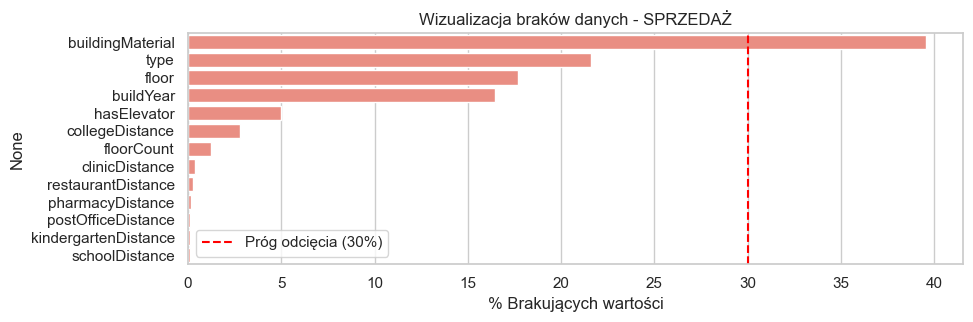

,Liczba,% Braków
buildingMaterial,28997,40.93%
buildYear,19682,27.78%
type,16762,23.66%
floor,8613,12.16%
hasElevator,3924,5.54%
floorCount,1379,1.95%
collegeDistance,874,1.23%
restaurantDistance,154,0.22%
pharmacyDistance,80,0.11%
clinicDistance,50,0.07%


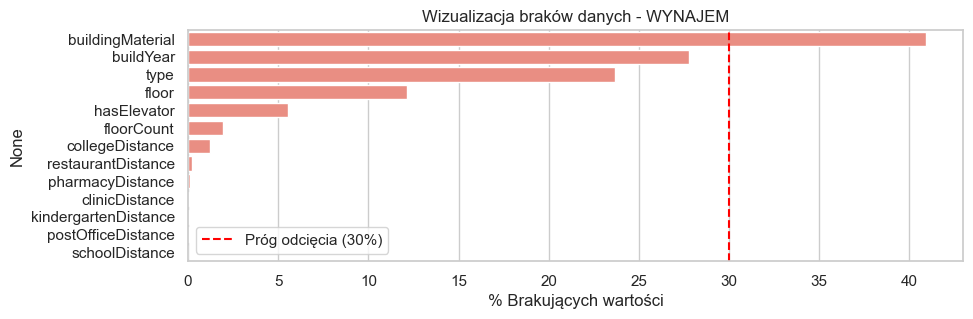

In [ ]:
def analyze_dataframe(df, df_name, plot_missing=True):
    n_rows, n_cols = df.shape

    # A. Braki danych
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        table_html = "<p><b>Brak brakujących danych (NaN).</b></p>"
    else:
        missing_pct = (missing / n_rows) * 100
        missing_df = pd.DataFrame({'Liczba': missing, '% Braków': missing_pct})
        missing_df = missing_df.sort_values(by='% Braków', ascending=False)
        
        # Konwersja tabeli na HTML z kolorowaniem
        table_html = missing_df.head(10).style.background_gradient(cmap='Reds', subset=['% Braków'])\
            .format({'% Braków': '{:.2f}%'})\
            .set_caption("Top 10 brakujących danych")\
            .set_table_attributes('style="width:100%"')\
            .to_html()

    # B. Duplikaty
    n_dupl = df.duplicated().sum()
    n_dupl_logic = 0
    if 'id' in df.columns and 'snapshot_date' in df.columns:
        n_dupl_logic = df.duplicated(subset=['id', 'snapshot_date']).sum()

    # C. Sanity Check (Błędy wartości)
    bad_price = (df['price'] <= 0).sum()
    bad_area = ((df['squareMeters'] < 10) | (df['squareMeters'] > 1000)).sum()
    
    
    # Tworzymy panel HTML: Prawa kolumna (Tabela), Lewa kolumna (Tekst/Statystyki)
    dashboard_html = f"""
    <div style="display: flex; flex-direction: row; gap: 40px; align-items: flex-start;">
        <div style="flex: 1; min-width: 300px; padding: 15px; border-radius: 8px;">
            <h2> RAPORT JAKOŚCI DANYCH: {df_name} </h2>

            <p><b>Liczba obserwacji:</b> {n_rows:,}</p>
            
            <hr>
            
            <p><b>Duplikaty:</b></p>
            <ul style="margin-top: 5px;">
                <li>Pełne (dubel wiersza): <b>{n_dupl}</b></li>
                <li>Logiczne (id + data): <b>{n_dupl_logic}</b></li>
            </ul>
            
            <hr>
            
            <p><b>Sanity Check (Błędy):</b></p>
            <ul style="margin-top: 5px;">
                <li>Cena <= 0 PLN: <b style="color: {'red' if bad_price > 0 else 'green'}">{bad_price}</b></li>
                <li>Metraż < 10m² lub > 1000m²: <b style="color: {'red' if bad_area > 0 else 'green'}">{bad_area}</b></li>
            </ul>
        </div>
        <div style="flex: 1; min-width: 300px;">
            {table_html}
        </div>
    </div>
    """
    
    display(HTML(dashboard_html))
    
    # Wykres
    if plot_missing and not missing.empty:
        plt.figure(figsize=(10, 3))
        sns.barplot(x=missing_df['% Braków'], y=missing_df.index, color='salmon')
        plt.title(f'Wizualizacja braków danych - {df_name}')
        plt.axvline(x=30, color='red', linestyle='--', label='Próg odcięcia (30%)')
        plt.xlabel('% Brakujących wartości')
        plt.legend()
        plt.show()

# Wywołanie testowe
analyze_dataframe(df_sell, "SPRZEDAŻ")
analyze_dataframe(df_rent, "WYNAJEM")

### Wnioski z analizy braków i decyzje:

Na podstawie powyższego raportu podejmujemy następujące kroki w procesie czyszczenia (`Data Cleaning`):

1.  **Usuwanie kolumn z dużą liczbą braków:** Zmienne, które mają powyżej 30-40% braków (np. często `condition`, `buildingMaterial`), niosą zbyt mało informacji, by być użyteczne, a ich imputacja byłaby obarczona dużym błędem. Zostaną usunięte.
2.  **Imputacja:** Dla zmiennych kluczowych z niewielką liczbą braków (np. `floor`, `buildYear`) zastosujemy w późniejszym etapie (przy modelowaniu) uzupełnianie medianą lub modą.
3.  **Usuwanie "śmieciowych" rekordów:** Zidentyfikowane oferty z ceną $\le 0$ lub nierealnym metrażem (np. 1 m²) traktujemy jako błędy wprowadzania danych i usuwamy je całkowicie, aby nie zaburzały statystyk (średniej, odchylenia).

### Automatyzacja procesu czyszczenia danych

Na podstawie wniosków z analizy jakości (`Sanity Check`) definiujemy funkcję `clean_data`, która standaryzuje proces oczyszczania dla obu zbiorów (sprzedaży i wynajmu). Procedura składa się z trzech kluczowych etapów:

1.  **Eliminacja duplikatów:**
    * Usuwamy duplikaty techniczne (całkowicie identyczne wiersze).
    * Usuwamy duplikaty logiczne: sytuacje, w których to samo mieszkanie (`id`) pojawia się wielokrotnie w ramach jednego zrzutu danych (`snapshot_date`). Pozostawiamy tylko pierwsze wystąpienie, aby uniknąć przekłamania statystyk (np. sztucznego zawyżania liczby ofert).

2.  **Filtrowanie domenowe (Hard Rules):**
    * Zastosowano reguły biznesowe w celu odrzucenia błędnych rekordów.
    * **Cena:** Musi być dodatnia (`price > 0`).
    * **Metraż:** Ograniczono analizę do lokali o powierzchni od **10 m²** (eliminacja miejsc postojowych/komórek błędnie wpisanych jako mieszkania) do **500 m²** (eliminacja obiektów komercyjnych lub błędów rzędu wielkości).

3.  **Redukcja rzadkich cech:**
    * Automatycznie usuwamy kolumny, w których brakuje ponad **50% danych**. Zmienne o tak niskim pokryciu (np. rzadko wypełniane pola opcjonalne) są bezużyteczne w modelowaniu, a ich imputacja byłaby obarczona zbyt dużym błędem.

Funkcja raportuje procent odrzuconych rekordów, co pozwala kontrolować, czy nie tracimy zbyt dużej części zbioru danych.

In [ ]:
def clean_data(df):
    df_clean = df.copy()
    start_len = len(df_clean)
    
    # 1. Usuwanie duplikatów
    df_clean = df_clean.drop_duplicates()
    if 'id' in df_clean.columns and 'snapshot_date' in df_clean.columns:
        df_clean = df_clean.drop_duplicates(subset=['id', 'snapshot_date'], keep='first')

    # 2. Usuwanie błędów logicznych (Cena i Metraż)
    # Zakładamy, że mieszkanie musi kosztować > 1000 zł i mieć > 10 m2
    mask_correct = (df_clean['price'] > 0) & \
                   (df_clean['squareMeters'] >= 10) & \
                   (df_clean['squareMeters'] <= 500)
    
    df_clean = df_clean[mask_correct]
    
    # 3. (Opcjonalnie) Usuwanie kolumn z > 50% braków
    # Tutaj przykład automatyczny, ale można też ręcznie: df.drop(columns=['condition'], ...)
    threshold = 0.5 * len(df_clean)
    df_clean = df_clean.dropna(thresh=threshold, axis=1)
    
    # Raport skuteczności
    end_len = len(df_clean)
    dropped = start_len - end_len
    print(f"Czyszczenie zakończone.\nUsunięto {dropped} rekordów ({dropped/start_len:.2%}).")
    print(f"Pozostało: {end_len} obserwacji.")
    return df_clean

# Zastosowanie czyszczenia
print("--- CZYSZCZENIE ZBIORU SPRZEDAŻY ---")
df_sell = clean_data(df_sell)

print("\n--- CZYSZCZENIE ZBIORU WYNAJMU ---")
df_rent = clean_data(df_rent)

--- CZYSZCZENIE ZBIORU SPRZEDAŻY ---
Czyszczenie zakończone.
Usunięto 0 rekordów (0.00%).
Pozostało: 195568 obserwacji.

--- CZYSZCZENIE ZBIORU WYNAJMU ---
Czyszczenie zakończone.
Usunięto 0 rekordów (0.00%).
Pozostało: 70847 obserwacji.


Po tych wszystkich operacjach wyświetlamy pierwsze 10 wierszy dla ofert wynajmu i sprzedaży.

In [ ]:
print("df_rent (10 pierwszych wiersze):")
display(df_rent.head(10))

print("\ndf_sell (10 pierwszych wiersze):")
display(df_sell.head(10))

df_rent (10 pierwsze wiersze):


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,source_file,snapshot_date,snapshot_year,snapshot_month,price_per_m2
195568,2a1a6db97ff122d6bc148abb6f0e498a,szczecin,blockOfFlats,52.00,2.0,3.0,3.0,2008.0,53.460535,14.545416,4.26,2.0,0.753,1.049,0.595,0.674,0.229,2.200,0.307,condominium,brick,yes,yes,no,no,no,3500,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,67.307692
195569,5a0cb42c088eadf75aa98a4118640048,szczecin,blockOfFlats,57.00,3.0,NaN,10.0,1976.0,53.440955,14.566024,1.98,14.0,0.126,0.875,0.586,0.058,0.129,1.323,0.189,condominium,NaN,no,yes,yes,no,no,3000,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,52.631579
195570,996722490efcb4b34d48bb84a9a72838,szczecin,NaN,43.40,2.0,3.0,4.0,NaN,53.435746,14.560764,1.37,17.0,0.265,0.373,0.385,0.364,0.116,0.714,0.211,condominium,NaN,no,yes,no,no,no,1900,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,43.778802
195571,50d75c688530b9a61ba505301e0b94a9,szczecin,apartmentBuilding,32.60,2.0,5.0,6.0,2021.0,53.421582,14.541572,1.30,16.0,0.081,0.565,0.223,0.482,0.151,0.689,0.192,condominium,brick,no,yes,yes,no,no,2500,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,76.687117
195572,9b187f4203adabf466fd08610d8f4e5e,szczecin,apartmentBuilding,72.00,3.0,6.0,6.0,2014.0,53.450010,14.547230,3.10,11.0,0.313,1.065,0.331,0.234,0.496,1.387,0.315,condominium,brick,no,yes,yes,no,yes,2999,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,41.652778
195573,ba4d70d65d1024ee13929ca82bfc92f6,szczecin,blockOfFlats,52.00,2.0,1.0,3.0,2006.0,53.427400,14.488100,4.85,6.0,0.607,0.485,0.247,0.399,0.600,3.003,0.458,condominium,concreteSlab,yes,no,no,no,no,2300,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,44.230769
195574,195bf5124c9fd720ca3ff7aeff9ca83f,szczecin,blockOfFlats,45.94,2.0,4.0,10.0,1978.0,53.433567,14.539891,1.80,61.0,0.223,0.382,0.332,0.211,0.051,0.155,0.125,condominium,concreteSlab,no,yes,yes,no,no,2500,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,54.418807
195575,03a41e8ec8ebdc1dd5a86d65ae3de54e,szczecin,blockOfFlats,54.00,2.0,NaN,3.0,2002.0,53.412600,14.541100,1.78,3.0,0.635,0.901,0.673,0.126,0.132,1.021,0.383,condominium,brick,yes,yes,yes,no,yes,2600,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,48.148148
195576,aae4994ab375e107dcc375f3360bd3d9,szczecin,tenement,32.00,1.0,2.0,4.0,1930.0,53.434836,14.548864,1.50,51.0,0.101,0.107,0.154,0.159,0.048,0.537,0.271,condominium,brick,no,no,NaN,no,no,1500,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,46.875000
195577,b83458393eb79b3ecdb13de56a6e2676,szczecin,blockOfFlats,76.38,3.0,1.0,1.0,1954.0,53.435478,14.512039,3.51,11.0,0.367,0.850,0.408,0.122,0.416,1.272,0.278,condominium,brick,yes,no,no,no,no,3600,apartments_rent_pl_2023_11.csv,2023-11-01,2023,11,47.132757



df_sell (10 pierwsze wiersze):


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,source_file,snapshot_date,snapshot_year,snapshot_month,price_per_m2
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,6.53,9.0,0.118,1.389,0.628,0.105,1.652,NaN,0.413,condominium,concreteSlab,yes,yes,yes,no,yes,415000,apartments_pl_2023_08.csv,2023-08-01,2023,8,6587.301587
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,NaN,53.442692,14.559690,2.15,16.0,0.273,0.492,0.652,0.291,0.348,1.404,0.205,cooperative,concreteSlab,no,yes,yes,no,yes,395995,apartments_pl_2023_08.csv,2023-08-01,2023,8,10999.861111
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,3.24,9.0,0.275,0.672,0.367,0.246,0.300,1.857,0.280,condominium,brick,no,no,no,no,no,565000,apartments_pl_2023_08.csv,2023-08-01,2023,8,7737.606135
3,0a68cd14c44ec5140143ece75d739535,szczecin,tenement,87.60,3.0,2.0,3.0,NaN,53.435100,14.532900,2.27,32.0,0.175,0.259,0.223,0.359,0.101,0.310,0.087,condominium,brick,yes,yes,no,no,yes,640000,apartments_pl_2023_08.csv,2023-08-01,2023,8,7305.936073
4,f66320e153c2441edc0fe293b54c8aeb,szczecin,blockOfFlats,66.00,3.0,1.0,3.0,NaN,53.410278,14.503611,4.07,1.0,0.218,1.690,0.504,0.704,0.501,2.138,0.514,condominium,NaN,no,no,no,no,no,759000,apartments_pl_2023_08.csv,2023-08-01,2023,8,11500.000000
5,2e190fcd6934978ca36d86ba41e842fc,szczecin,blockOfFlats,63.30,3.0,2.0,4.0,1997.0,53.463100,14.572800,4.48,10.0,0.079,1.224,0.737,0.260,1.102,0.377,0.745,cooperative,concreteSlab,yes,yes,no,no,yes,499000,apartments_pl_2023_08.csv,2023-08-01,2023,8,7883.096367
6,ec27024bfcd012728617a35dad2cb6b8,szczecin,blockOfFlats,47.45,2.0,2.0,10.0,1974.0,53.450232,14.562625,2.99,18.0,0.327,0.378,0.234,0.262,0.244,1.736,0.277,condominium,concreteSlab,no,no,yes,no,yes,370000,apartments_pl_2023_08.csv,2023-08-01,2023,8,7797.681770
7,d3e0e36529df3360849ec40168c10755,szczecin,apartmentBuilding,60.08,2.0,3.0,4.0,2009.0,53.454685,14.551520,3.53,8.0,0.572,0.784,0.305,0.435,0.257,1.945,0.155,condominium,brick,no,yes,yes,no,no,629000,apartments_pl_2023_08.csv,2023-08-01,2023,8,10469.374168
8,7e1981e920d763d6237c5bdcf13cf5b7,szczecin,blockOfFlats,47.76,2.0,8.0,12.0,1980.0,53.458869,14.536403,4.27,6.0,0.345,0.520,0.336,0.500,0.265,1.879,0.420,condominium,concreteSlab,no,yes,yes,no,yes,399000,apartments_pl_2023_08.csv,2023-08-01,2023,8,8354.271357
9,4a04a9c54d8281e3ec23df031e538d85,szczecin,tenement,72.09,4.0,2.0,3.0,1890.0,53.435092,14.559612,1.30,22.0,0.232,0.292,0.356,0.301,0.199,0.653,0.199,condominium,brick,yes,no,no,no,yes,325000,apartments_pl_2023_08.csv,2023-08-01,2023,8,4508.253572


## 6. Badanie Zależności i Korelacje

W tym kroku identyfikujemy zmienne, które mają największy wpływ na cenę mieszkania (tzw. *predyktory*). Analiza obejmuje:
1.  **Macierz korelacji:** Sprawdzenie siły zależności liniowej (Pearson) między cechami numerycznymi a zmienną celu.
2.  **Analizę `log_price`:** Weryfikację, czy zlogarytmowanie ceny (zmienna celu) zwiększa siłę korelacji (co jest typowe dla rozkładów prawoskośnych).
3.  **Wizualizację trendów:** Wykresy punktowe badające relację Cena vs Metraż (dla kluczowych miast) oraz wpływ lokalizacji na cenę za m².

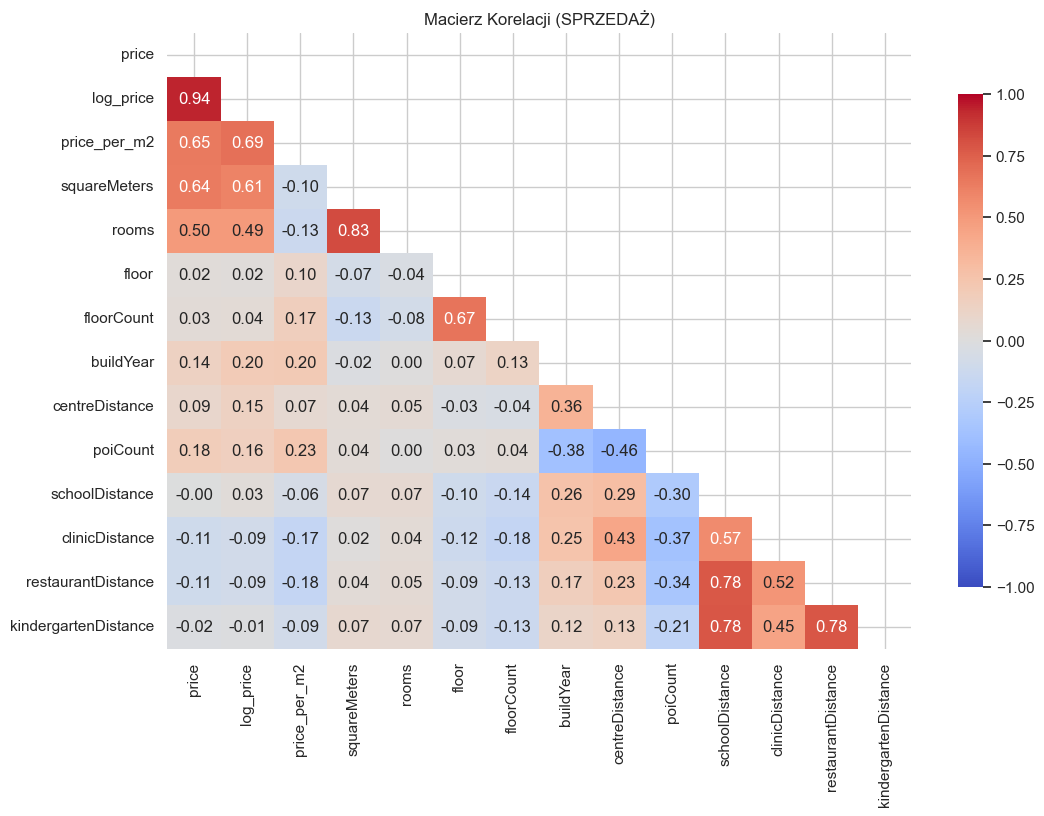


TOP 10 Korelacji ze zmiennymi celu (SPRZEDAŻ):


,Cecha (log_price),Korelacja (log_price),|,Cecha (price_per_m2),Korelacja (price_per_m2)
0,squareMeters,0.608,|,poiCount,0.228
1,rooms,0.494,|,buildYear,0.204
2,buildYear,0.197,|,restaurantDistance,-0.179
3,poiCount,0.161,|,clinicDistance,-0.174
4,centreDistance,0.148,|,floorCount,0.172
5,restaurantDistance,-0.092,|,rooms,-0.132
6,clinicDistance,-0.089,|,squareMeters,-0.103
7,floorCount,0.042,|,floor,0.095
8,schoolDistance,0.030,|,kindergartenDistance,-0.088
9,floor,0.018,|,centreDistance,0.069


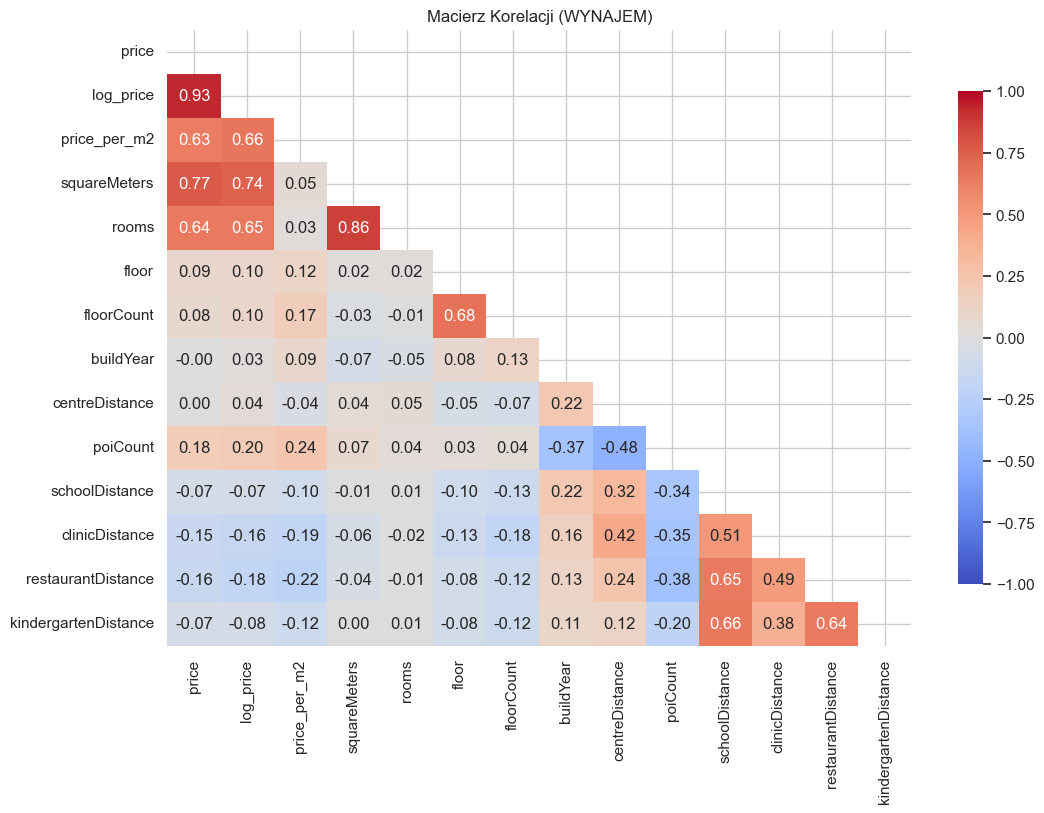


TOP 10 Korelacji ze zmiennymi celu (WYNAJEM):


,Cecha (log_price),Korelacja (log_price),|,Cecha (price_per_m2),Korelacja (price_per_m2)
0,squareMeters,0.744,|,poiCount,0.236
1,rooms,0.645,|,restaurantDistance,-0.222
2,poiCount,0.199,|,clinicDistance,-0.194
3,restaurantDistance,-0.181,|,floorCount,0.175
4,clinicDistance,-0.164,|,floor,0.124
5,floorCount,0.100,|,kindergartenDistance,-0.117
6,floor,0.096,|,schoolDistance,-0.100
7,kindergartenDistance,-0.077,|,buildYear,0.087
8,schoolDistance,-0.067,|,squareMeters,0.055
9,centreDistance,0.038,|,centreDistance,-0.037


In [ ]:
def analyze_correlations(df, dataset_name, method='pearson'):
    # 1. Przygotowanie danych roboczych
    df_corr = df.copy()
    # Logarytmowanie ceny (często linearyzuje zależności)
    df_corr['log_price'] = np.log1p(df_corr['price'])
    
    # Wybór zmiennych numerycznych do analizy
    target_cols = ['price', 'log_price', 'price_per_m2']
    feature_cols = [
        'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear', 
        'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 
        'restaurantDistance', 'kindergartenDistance'
    ]
    # Bierzemy tylko te kolumny, które faktycznie istnieją w DF
    available_cols = target_cols + [c for c in feature_cols if c in df_corr.columns]
    
    # 2. Obliczenie macierzy korelacji
    corr_matrix = df_corr[available_cols].corr(method=method)
    
    # 3. Wizualizacja - Heatmapa
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Ukrywamy górny trójkąt (duplikaty)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                mask=mask, vmin=-1, vmax=1, center=0, cbar_kws={"shrink": .8})
    plt.title(f'Macierz Korelacji ({dataset_name})')
    plt.show()
    
    # 4. Ranking najważniejszych cech (Tabela)
    print(f"\nTOP 10 Korelacji ze zmiennymi celu ({dataset_name}):")
    
    # Pobieramy korelacje dla log_price i price_per_m2
    rank_log = corr_matrix['log_price'].drop(target_cols, errors='ignore').abs().sort_values(ascending=False).head(10)
    rank_m2 = corr_matrix['price_per_m2'].drop(target_cols, errors='ignore').abs().sort_values(ascending=False).head(10)
    
    # Funkcje pomocnicze do budowy tabeli
    idx1, val1 = rank_log.index.tolist(), corr_matrix.loc[rank_log.index, 'log_price'].values
    idx2, val2 = rank_m2.index.tolist(), corr_matrix.loc[rank_m2.index, 'price_per_m2'].values
    max_len = max(len(idx1), len(idx2))
    
    def pad(l, size, fill): return l + [fill] * (size - len(l))

    ranking_df = pd.DataFrame({
        'Cecha (log_price)': pad(idx1, max_len, '-'),
        'Korelacja (log_price)': pad(list(val1), max_len, np.nan),
        ' | ': ['|'] * max_len,
        'Cecha (price_per_m2)': pad(idx2, max_len, '-'),
        'Korelacja (price_per_m2)': pad(list(val2), max_len, np.nan)
    })
    
    # Wyświetlenie sformatowanej tabeli
    display(ranking_df.style.background_gradient(
        cmap='coolwarm', 
        subset=['Korelacja (log_price)', 'Korelacja (price_per_m2)'], 
        vmin=-1, vmax=1
    ).format("{:.3f}", subset=['Korelacja (log_price)', 'Korelacja (price_per_m2)']))

# Wywołanie dla wyczyszczonych danych
analyze_correlations(df_sell, "SPRZEDAŻ")
analyze_correlations(df_rent, "WYNAJEM")

### Wnioski z analizy korelacji:

1.  **Dominacja metrażu:** Najsilniejszym predyktorem ceny całkowitej jest powierzchnia mieszkania (`squareMeters`) oraz liczba pokoi (`rooms`). Korelacja jest silna i dodatnia.
2.  **Przewaga logarytmu:** Analiza potwierdza (patrz tabela), że zmienna `log_price` wykazuje zazwyczaj silniejszą korelację z cechami niż surowa cena (`price`). Jest to argument za trenowaniem modeli regresyjnych na zlogarytmowanej zmiennej celu.
3.  **Lokalizacja a cena za m²:** Cena za m² (`price_per_m2`) zależy głównie od lokalizacji i otoczenia. Silna korelacja z `poiCount` (punkty usługowe) oraz ujemna korelacja z dystansem (`centreDistance`, `restaurantDistance`) wskazują, że bliskość centrum i usług drastycznie podnosi standard cenowy.
4.  **Współliniowość:** Zauważalna jest wysoka korelacja między `squareMeters` a `rooms`. W prostych modelach liniowych może to prowadzić do problemu współliniowości, dlatego warto rozważyć użycie modelu odpornego, np. drzew decyzyjnych.

### Analiza Rozkładu Zmiennej Celu (Skośność)

Modele regresji liniowej najlepiej działają, gdy zmienna celu ma rozkład zbliżony do normalnego (Krzywa Gaussa).
Poniżej porównujemy rozkład surowej ceny (`price`) oraz jej logarytmu (`log_price`).

* **Skośność (Skewness):** Miara asymetrii rozkładu.
    * Wartość > 1 oznacza silną asymetrię prawostronną (dużo tanich, mało drogich).
    * Wartość bliska 0 oznacza rozkład symetryczny (idealny dla modelu).

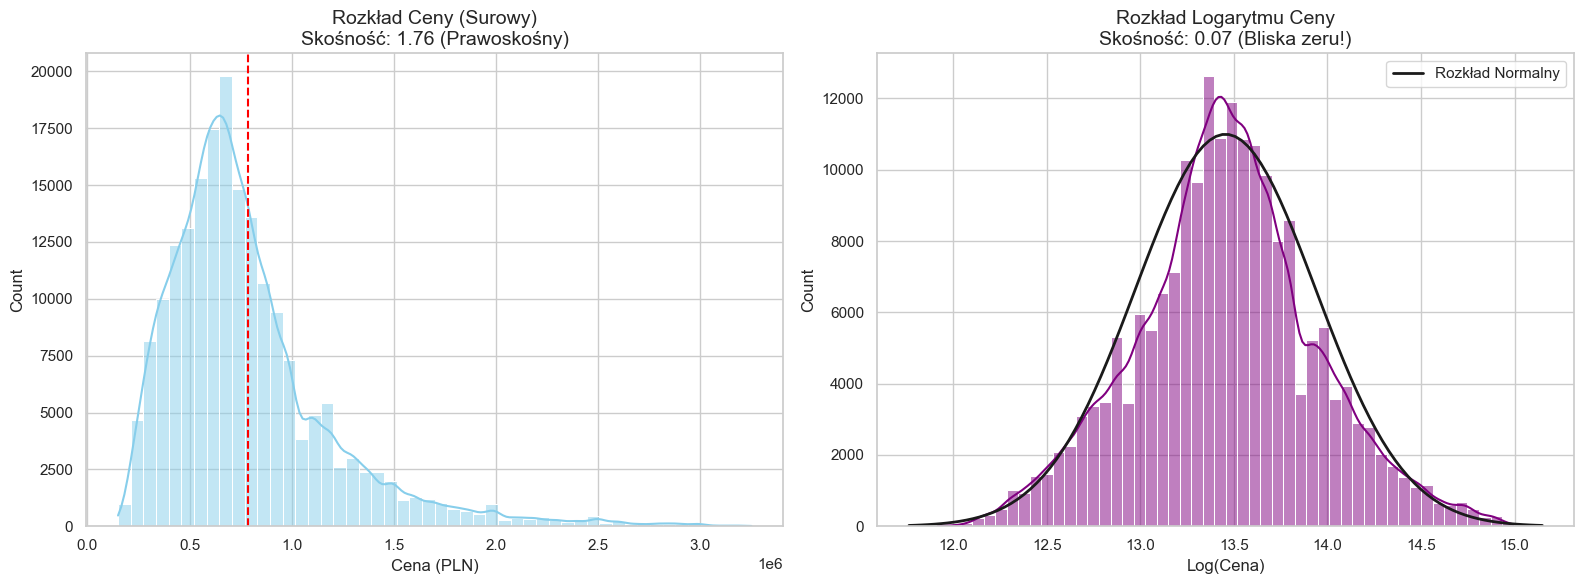

In [ ]:
# Wybieramy dane (np. sprzedaż)
df_dist = df_sell.copy()

# Obliczenie logarytmu
df_dist['log_price'] = np.log1p(df_dist['price'])

# Obliczenie skośności
skew_raw = df_dist['price'].skew()
skew_log = df_dist['log_price'].skew()

# Wizualizacja "Przed i Po"
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Rozkład surowy (PLN)
sns.histplot(df_dist['price'], bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title(f'Rozkład Ceny (Surowy)\nSkośność: {skew_raw:.2f} (Prawoskośny)', fontsize=14)
axes[0].set_xlabel('Cena (PLN)')
axes[0].axvline(df_dist['price'].mean(), color='red', linestyle='--', label='Średnia')

# 2. Rozkład logarytmiczny
sns.histplot(df_dist['log_price'], bins=50, kde=True, color='purple', ax=axes[1])
# Dopasowanie idealnej krzywej normalnej dla porównania
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_dist['log_price'].mean(), df_dist['log_price'].std())
axes[1].plot(x, p * len(df_dist) * (xmax - xmin)/50, 'k', linewidth=2, label='Rozkład Normalny')

axes[1].set_title(f'Rozkład Logarytmu Ceny\nSkośność: {skew_log:.2f} (Bliska zeru)', fontsize=14)
axes[1].set_xlabel('Log(Cena)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Wnioski z analizy rozkładu zmiennej celu:
Wykresy jednoznacznie pokazują, że surowe ceny mają silny rozkład prawoskośny (skośność > 1). Zastosowanie transformacji logarytmicznej "prostuje" rozkład, czyniąc go niemal idealnie symetrycznym (skośność bliska 0). Jest to ostateczne potwierdzenie, że **model powinien przewidywać `log_price`**, a nie surową kwotę.

### Analiza porównawcza rynków lokalnych

Rynek nieruchomości w Polsce nie jest jednorodny. Aby zweryfikować hipotezę, że cena mieszkania zależy nie tylko od jego metrażu, ale także od miasta, w którym się znajduje, przeprowadzamy analizę dla 4 największych rynków: Warszawy, Krakowa, Wrocławia i Poznania.

Wykorzystujemy wykres punktowy z naniesioną linią regresji (`lmplot`), rozbity na panele. Pozwoli to porównać nachylenie krzywych cenowych – im bardziej stroma linia, tym droższy jest każdy kolejny metr kwadratowy w danym mieście.

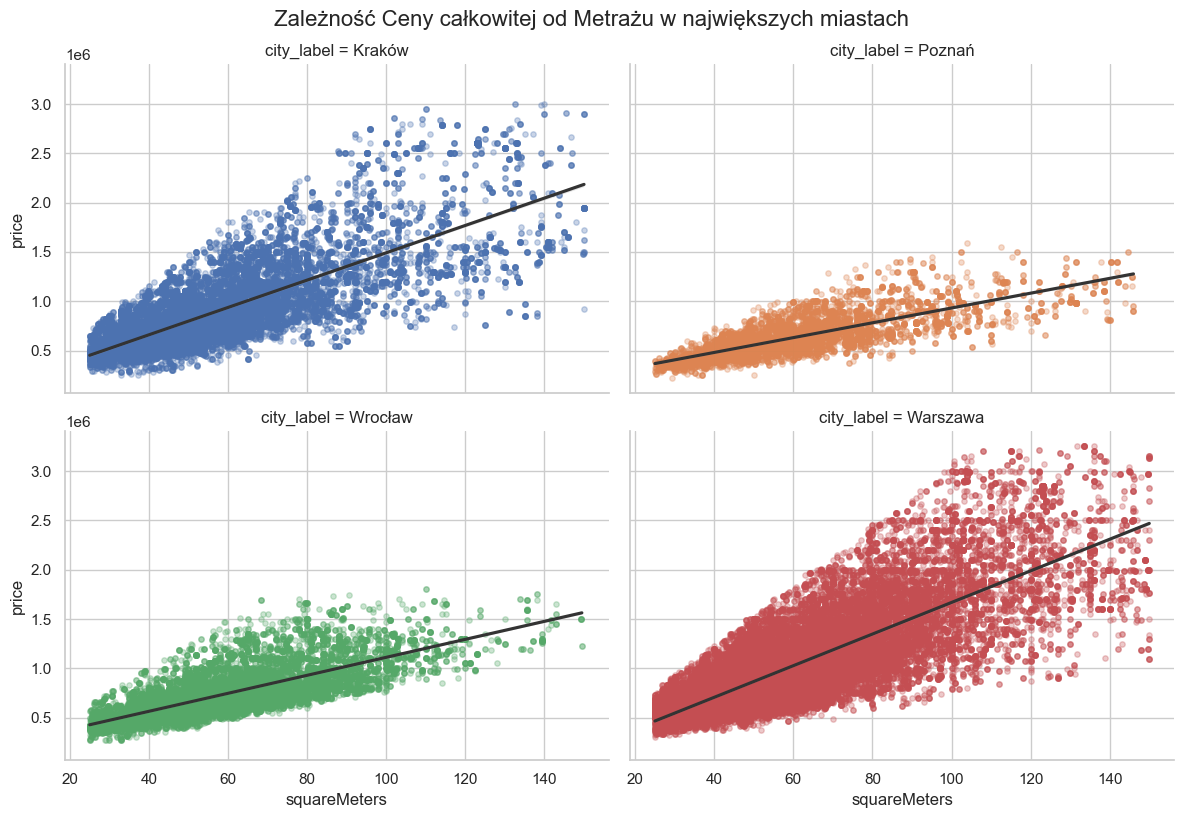

In [ ]:
# Używamy nazw bez polskich znaków, bo takie są w pliku CSV
top_cities_keys = ['warszawa', 'krakow', 'wroclaw', 'poznan'] 

# Słownik do mapowania nazw na ładne etykiety z polskimi znakami
city_labels = {
    'warszawa': 'Warszawa', 
    'krakow': 'Kraków', 
    'wroclaw': 'Wrocław', 
    'poznan': 'Poznań'
}

# Tworzymy kopię danych tylko dla wybranych miast
df_plot = df_sell[df_sell['city'].isin(top_cities_keys)].copy()
df_plot['city_label'] = df_plot['city'].map(city_labels)

# lmplot automatycznie rysuje punkty oraz dopasowuje linię regresji liniowej
g = sns.lmplot(
    data=df_plot, 
    x='squareMeters', 
    y='price', 
    col='city_label',   # Osobny wykres dla każdego miasta
    col_wrap=2,         # Układ w dwóch kolumnach
    hue='city_label',   # Kolorowanie wg miasta dla lepszej czytelności
    height=4, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 15}, # Przezroczyste punkty, by widzieć zagęszczenie
    line_kws={'color': '#333333'}        # Ciemna linia trendu dla kontrastu
)
g.fig.suptitle('Zależność Ceny całkowitej od Metrażu w największych miastach', y=1.02, fontsize=16)
plt.show()

### Analiza wpływu lokalizacji (Mapa gęstości)

Drugim kluczowym czynnikiem cenotwórczym jest odległość od centrum (`centreDistance`). Ponieważ zbiór danych jest duży, zwykły wykres punktowy byłby nieczytelny (problem nakładania się punktów, tzw. *overplotting*).

Zamiast tego stosujemy wykres heksagonalny (hexbin plot), który działa jak mapa termiczna.
* **Oś X:** Odległość od centrum (km).
* **Oś Y:** Cena za m² (PLN).
* **Kolor:** Liczba ofert w danym obszarze (skala logarytmiczna).

Dzięki temu zobaczymy nie tylko trend cenowy, ale także strukturę podaży – w jakiej odległości od centrum dostępnych jest najwięcej mieszkań.

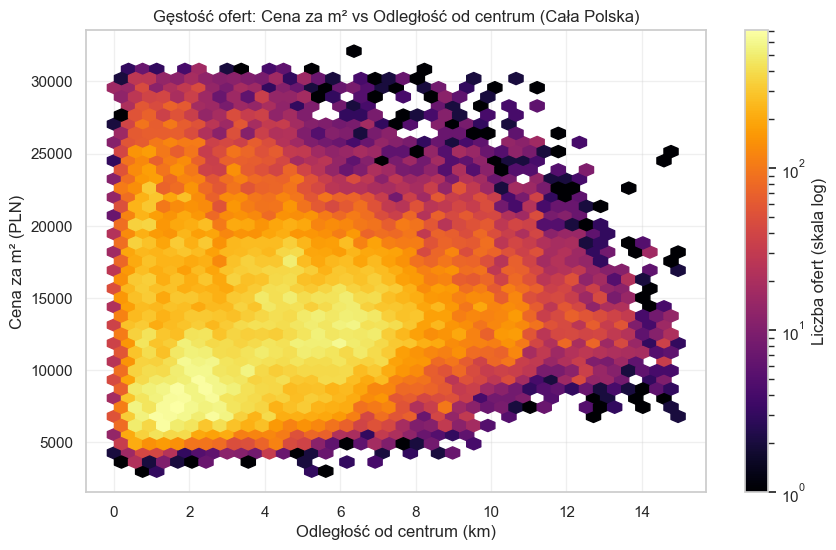

In [ ]:
plt.figure(figsize=(10, 6))

# Odsiewamy skrajne wartości (outliery) dla czytelności wykresu:
# - Dystans < 15 km (skupiamy się na tkance miejskiej)
# - Cena/m2 < 35 000 zł (odrzucamy luksusowe apartamenty zaburzające skalę)
df_hex = df_sell[
    (df_sell['centreDistance'] < 15) & 
    (df_sell['price_per_m2'] < 35000)
]

# Rysujemy hexbin
hb = plt.hexbin(
    df_hex['centreDistance'], 
    df_hex['price_per_m2'], 
    gridsize=40,    # Wielkość "kafelków"
    cmap='inferno', # Paleta barw (od czarnego do żółtego)
    mincnt=1,       # Nie rysuj pustych heksagonów
    bins='log'      # Skala logarytmiczna dla kolorów (lepiej pokazuje różnice w gęstości)
)

cb = plt.colorbar(hb, label='Liczba ofert (skala log)')
plt.title('Gęstość ofert: Cena za m² vs Odległość od centrum (Cała Polska)')
plt.xlabel('Odległość od centrum (km)')
plt.ylabel('Cena za m² (PLN)')
plt.grid(True, alpha=0.3)
plt.show()

### Wnioski z analizy wizualnej:

1.  **Liniowość metrażu:** Wykresy panelowe (6a) potwierdzają silną, liniową zależność między metrażem a ceną we wszystkich badanych miastach. Punkty układają się wzdłuż linii regresji, co jest silnym argumentem za zastosowaniem **Regresji Liniowej** jako modelu bazowego.
2.  **Różnice w "cenie jednostkowej":** Nachylenie linii trendu (współczynnik kierunkowy) jest różne dla każdego miasta. W Warszawie linia jest najbardziej stroma, co oznacza, że każdy dodatkowy metr kwadratowy podnosi cenę końcową znacznie mocniej niż w Poznaniu czy Wrocławiu. Model musi więc uwzględniać miasto (cecha `city`) jako kluczowy predyktor.
3.  **Nieliniowy wpływ odległości:** Wykres gęstości (6b) ujawnia charakterystyczny kształt litery "L". Ceny są najwyższe i najbardziej zróżnicowane w ścisłym centrum (0-2 km), po czym gwałtownie spadają. W pasie 5-10 km od centrum ceny stabilizują się i są mniej zróżnicowane. Sugeruje to, że zależność ceny od dystansu **nie jest liniowa** (przypomina rozkład wykładniczy lub 1/x), co może wymagać transformacji tej cechy w procesie Feature Engineering.
4.  **Koncentracja podaży:** Najjaśniejsze obszary na wykresie heksagonalnym pokazują, że najwięcej ofert rynkowych znajduje się w przedziale 3–8 km od centrum, z cenami oscylującymi wokół średniej rynkowej (np. 10-15 tys. zł/m²).

----------------------------KONIEC----------------------------
Nad tym co niżej to trzeba się zastanowić

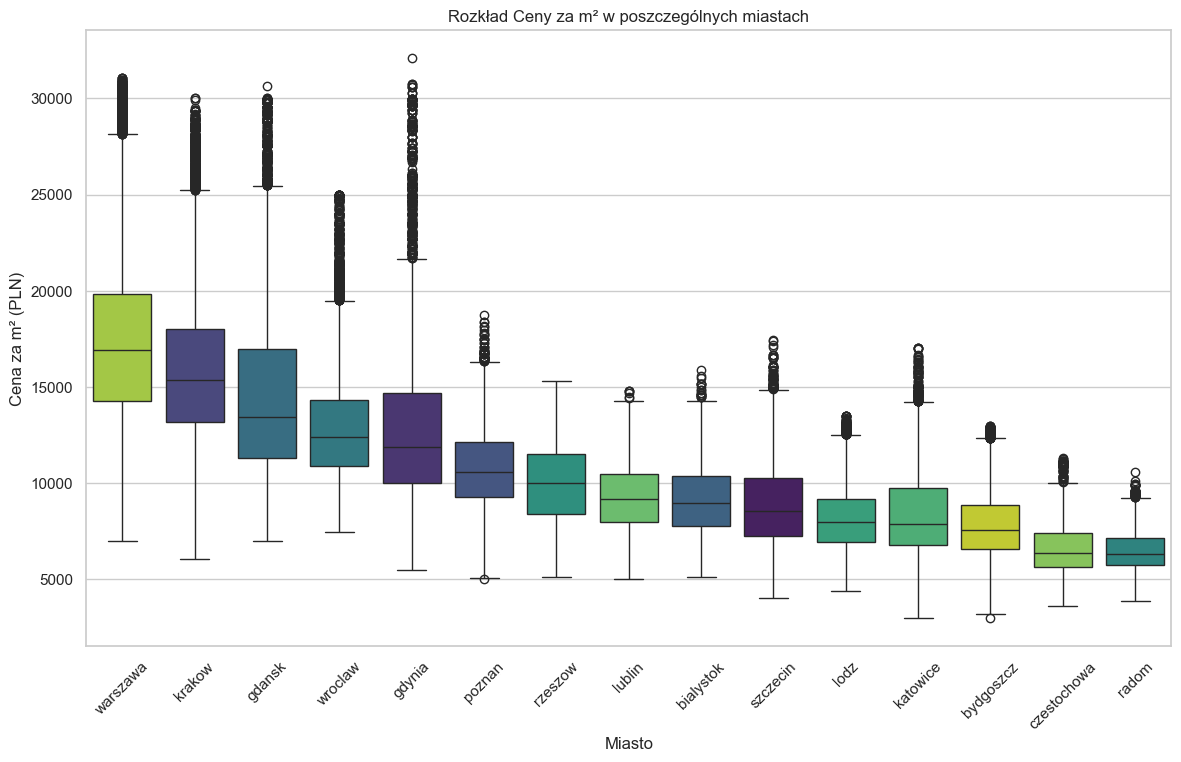

In [11]:
plt.figure(figsize=(14, 8))

# Sortowanie miast wg mediany ceny za m2
order_cities = df_sell.groupby('city')['price_per_m2'].median().sort_values(ascending=False).index

sns.boxplot(x='city', y='price_per_m2', data=df_sell, order=order_cities, hue='city', palette="viridis", legend=False)
plt.title('Rozkład Ceny za m² w poszczególnych miastach')
plt.xlabel('Miasto')
plt.ylabel('Cena za m² (PLN)')
plt.xticks(rotation=45)
plt.show()

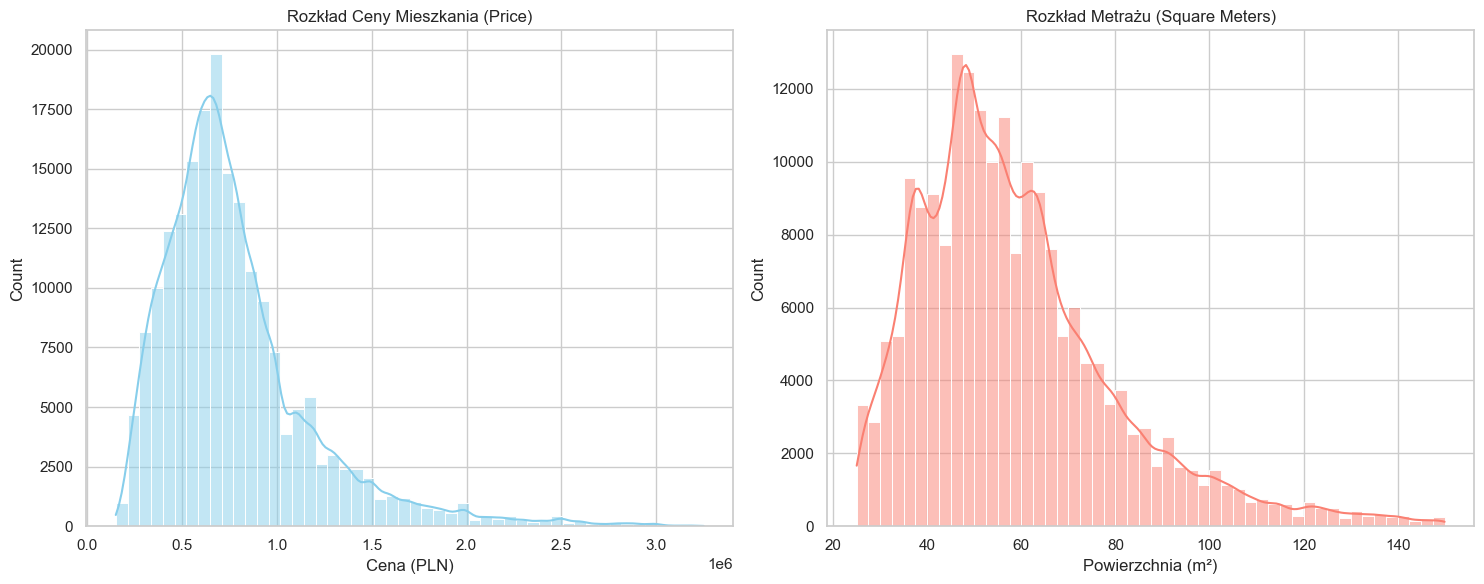

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Rozkład Ceny
sns.histplot(df_sell['price'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Rozkład Ceny Mieszkania (Price)')
axes[0].set_xlabel('Cena (PLN)')

# Rozkład Metrażu
sns.histplot(df_sell['squareMeters'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Rozkład Metrażu (Square Meters)')
axes[1].set_xlabel('Powierzchnia (m²)')

plt.tight_layout()
plt.show()

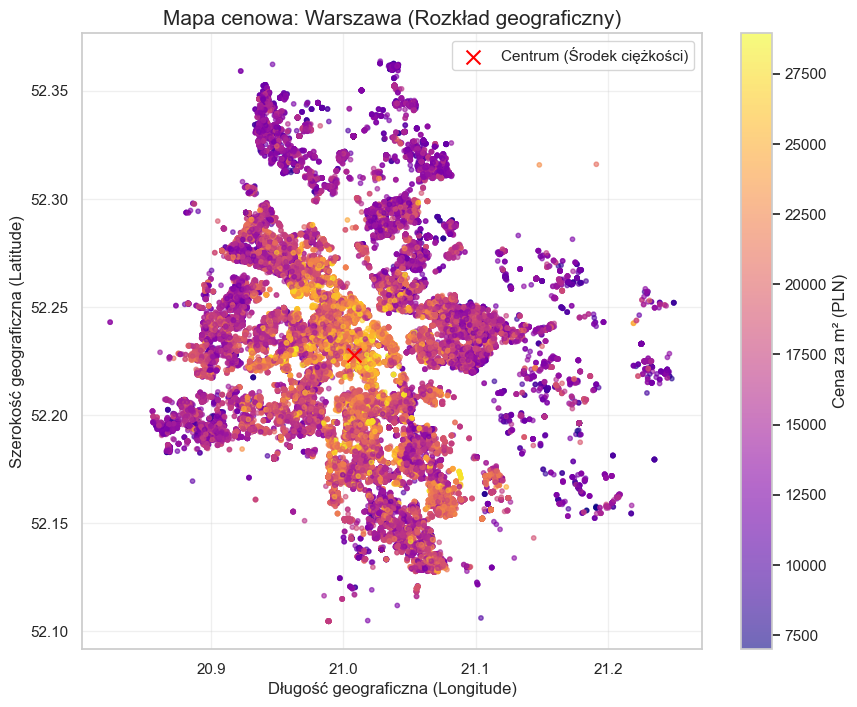

In [55]:
# Filtrujemy tylko Warszawę (dla czytelności mapy)
city_map = 'warszawa' # Pamiętaj o braku polskich znaków w bazie!
df_map = df_sell[df_sell['city'] == city_map].copy()

# Usuwamy skrajne outliery cenowe do mapy (żeby nie psuły skali kolorów)
q99 = df_map['price_per_m2'].quantile(0.99)
df_map = df_map[df_map['price_per_m2'] < q99]

plt.figure(figsize=(10, 8))

# Rysujemy Scatterplot, który udaje mapę
sc = plt.scatter(
    x=df_map['longitude'], 
    y=df_map['latitude'], 
    c=df_map['price_per_m2'], 
    cmap='plasma',          # Paleta kolorów (ciemny = tanio, jasny/żółty = drogo)
    s=10,                   # Rozmiar punktu
    alpha=0.6               # Przezroczystość
)

plt.colorbar(sc, label='Cena za m² (PLN)')
plt.title(f'Mapa cenowa: {city_map.capitalize()} (Rozkład geograficzny)', fontsize=15)
plt.xlabel('Długość geograficzna (Longitude)')
plt.ylabel('Szerokość geograficzna (Latitude)')
plt.grid(True, alpha=0.3)

# Opcjonalnie: Zaznaczamy centrum (dla orientacji)
center_lat = df_map['latitude'].mean()
center_lon = df_map['longitude'].mean()
plt.scatter(center_lon, center_lat, color='red', marker='x', s=100, label='Centrum (Środek ciężkości)')
plt.legend()

plt.show()